# <font color=cyan> Data Lake. Data extraction </font>



The main goal of this Sample is to retrieve account's cash balance and bank balance for every day after entered day. The sample uses Cash API to retrive balance. There is possible to download csv file with results.

## <font color='yellow'>Code for token generation and API management </font>


In [ ]:
#@title Select **servicePack** the Sample should run
from subprocess import getstatusoutput
servicePack = "DEMO" #@param ['DEMO'] {allow-input: true}

if servicePack == 'DEMO':
  branch = 'main'
else:
  branch = servicePack
print(branch)
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ") 
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git") 
import importlib
try:  
  importlib.reload(sample_requests)
except:
  print()
from Colab_shared_code_for_API_usage import sample_requests


In [2]:
#@title Import custom modules
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta, date
import dateutil.relativedelta
import calendar
from IPython.display import display, HTML
from google.colab import widgets
import ipywidgets
from IPython.display import display
from google.colab import files
import sys

## <font color='yellow'>Connect and retrieve token</font>

In [3]:
#@title <font color='lime'>Connect</font>
print('token:')
token = sample_requests.login()

token:
token 46f633ae-6c2d-4bce-abea-b428fc80239e


## <font color='yellow'>1. Export updated Accounts and their balances </font>

In [ ]:
import traceback 
#@title <font color='lime'>Show updated accounts</font>
Start_export = '2023-02-21'#@param {type:"date"}

# todo: check if start_export is correct
current_date = datetime.today()
current_month = current_date.month
last_month = current_month - 3 if current_month > 3 else current_month - 3 + 12  
last_year = current_date.year if current_month > 3 else current_date.year -1
last_day =  current_date.day 
try:
  today_a_3_month_ago = date(last_year, last_month, last_day)
except:
  last_day = calendar.monthlen(last_year, last_month)
  today_a_3_month_ago = date(last_year, last_month, last_day)
if(datetime.strptime(Start_export, "%Y-%m-%d").date() < today_a_3_month_ago):
  print("Start export date should be not earlier then 3 month ago")
  df1 = pd.DataFrame(columns = ['Company', 'Bank', 'Branch', 'Account', 'Currency', 'Created', 'Updated'])
else:
  request = '/v1/accounts?page.limit=1&filter=updateDate=ge='+ Start_export +',creationDate=ge=' + Start_export
  res1 = sample_requests.get_results(token, request)
  ppjson = sample_requests.js.loads(res1, parse_int=int)

  # convert json to dataFrame
  df1 = sample_requests.pd.json_normalize(ppjson['results']).filter(items=['uuid','company.code', 'bank.code', 'branch.code', 'code', 'currency.code', 'creationDate', 'updateDate'], axis =1)
  # Get results and append to previous unless next is absent.
  while True:
    try:
      next = ppjson['metadata']['links']['next']
      res1 = sample_requests.get_results(token, '/v1/accounts' + next[next.index('?'):])
      ppjson = sample_requests.js.loads(res1, parse_int=int)  
      df1 = df1.append(sample_requests.pd.json_normalize(ppjson['results']).filter(items=['uuid', 'company.code', 'bank.code', 'branch.code', 'code', 'currency.code', 'creationDate', 'updateDate'], axis =1), ignore_index = True)
    except:
      break
df1 = df1.rename(columns={'company.code':'Company', 'bank.code':'Bank', 'branch.code':'Branch', 'code':'Account', 'currency.code':'Currency', 'creationDate':'Created', 'updateDate':'Updated'})
if(df1.empty):
  df1 = pd.DataFrame(columns = ['Company', 'Bank', 'Branch', 'Account', 'Currency', 'Created', 'Updated'])
display(df1)
  

In [ ]:
#@title <font color='lime'>Show account balance</font>
import warnings
warnings.filterwarnings("ignore")
Account_code = 'HSBCSBXSTA'#@param {type:"string"}
all_accounts = False #@param {type:"boolean"}
Start_export = '2023-02-21'#@param {type:"date"}

#@markdown <font color='Orange'>Bank Balance Settings</font>

Balance_Type = 'END_OF_DAY' #@param['END_OF_DAY', 'INTRADAY']
Bank_Balance_Type = Balance_Type;

#@markdown <font color='Orange'>Cash Balance Settings</font>

dates_Type = 'TRANSACTION' #@param['TRANSACTION', 'VALUE']
Cash_Balance_Date_Type = dates_Type

Actual = True #@param {type:"boolean"}
Cash_Balance_Actual=Actual

Intraday = True #@param {type:"boolean"}
Cash_Balance_Intraday=Intraday

Estimated = True #@param {type:"boolean"}
Cash_Balance_Estimated=Estimated

Confirmed = True #@param {type:"boolean"}
Cash_Balance_Confirmed = Confirmed

df2 = df1
if not all_accounts:
  df2 = df2.loc[df2['Account'] == Account_code]
print('Procesing...')
for index, row in df2.iterrows():
  uuid = row['uuid']
  request = '/v1/cash-balances/accounts/' + uuid + '/balances?dateType=' + Cash_Balance_Date_Type + '&startDate=' + Start_export + '&endDate=' + datetime.strftime(datetime.today(), "%Y-%m-%d") + '&actual=' + str(Cash_Balance_Actual) + '&intraday=' + str(Cash_Balance_Intraday) + '&confirmedForecasts=' + str(Cash_Balance_Confirmed) + '&estimatedForecasts=' + str(Cash_Balance_Estimated)
  res_cash = sample_requests.get_results(token, request)
  res_cash = sample_requests.js.loads(res_cash, parse_int=int)
  cash_balance = res_cash['cashBalance']
  for day in cash_balance:  
    single_date = day['balanceDate']['date']   
    request = '/v1/bank-balances/accounts/' + uuid + '/balances?date=' + single_date + '&type=' + Bank_Balance_Type
    res = sample_requests.get_results(token, request)
    res = sample_requests.js.loads(res, parse_int=int)
    balance = 'Bank balance: ' + str(res['bankBalance']['amount']) + str(res['bankBalance']['currencyCode'])
    balance = balance + '\n Cash balance: ' + str(day['amount']) + str(day['currencyCode'])
    df2.at[index, single_date] = balance


display(HTML(df2.to_html().replace("\\n","<br>") ))

def on_button_balance(b):
  files.download('accounts_balance.csv')

df2.to_csv('accounts_balance.csv')
print("Please find  accounts_balance.csv file inside content folder or download.\n")
button = ipywidgets.widgets.Button(description='Download')
button.on_click(on_button_balance)
display(button)

## <font color='yellow'>2. Export Cash Flows via CRUD API vs TASK APIs </font>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#@title <font color='lime'>Export Cash Flows via CRUD API</font> 
Export_Period = 'LAST 7 DAYS' #@param['TODAY', 'LAST 7 DAYS', 'LAST 30 DAYS']
if Export_Period == 'TODAY':
  day = datetime.today().strftime("%Y-%m-%d") 
elif Export_Period == 'LAST 7 DAYS':
  day = datetime.today() - timedelta(days = 7)
  day = day.strftime("%Y-%m-%d") 
elif Export_Period == 'LAST 30 DAYS':
  day = datetime.today() - timedelta(days = 30)
  day = day.strftime("%Y-%m-%d") 
day = day + 'T00:00:00Z'
print('Processing...')
request3 = '/v1/cash-flows?dateType=UPDATE&filter=updateDateTime=ge='+ day
res3 = sample_requests.get_results(token, request3)
ppjson3 = sample_requests.js.loads(res3, parse_int=int)

df3 = sample_requests.pd.json_normalize(ppjson3['results']).filter(items=['account.code','flowCode.code', 'budgetCode.code', 'date.transactionDate', 'date.valueDate', 'date.accountingDate', 'date.updateDateTime', 'flowAmount.currency.code', 'flowAmount.value', 'flowAmount.amount', 'accountAmount.currency.code', 'accountAmount.value', 'accountAmount.amount', 'description', 'reference', 'origin', 'status'], axis =1)
# Get results and append to previous unless next is absent.
while True:
  try:
    next = ppjson3['metadata']['links']['next']
    res3 = sample_requests.get_results(token, '/v1/cash-flows' + next[next.index('?'):])
    ppjson3 = sample_requests.js.loads(res3, parse_int=int)  
    df3 = df3.append(sample_requests.pd.json_normalize(ppjson3['results']).filter(items=['account.code','flowCode.code', 'budgetCode.code', 'date.transactionDate', 'date.valueDate', 'date.accountingDate', 'date.updateDateTime', 'flowAmount.currency.code', 'flowAmount.value', 'accountAmount.currency.code', 'accountAmount.value', 'description', 'reference', 'origin', 'status'], axis =1), ignore_index = True)
  except:
    break

df3 = df3.rename(columns = {'account.code':'Account','flowCode.code':'flowCode', 'budgetCode.code':'budgetCode', 'date.transactionDate':'transactionDate', 'date.valueDate':'valueDate', 'date.accountingDate':'accountingDate', 'date.updateDateTime':'updateDateTime', 'flowAmount.currency.code':'flowCurrency', 'flowAmount.value':'flowAmount', 'flowAmount.amount':'flowAmount', 'accountAmount.currency.code':'accountCurrency', 'accountAmount.value':'accountAmount', 'accountAmount.amount':'accountAmount'})
df3= df3.drop_duplicates(ignore_index=True)
display(df3)

def on_button_balance_task(b):
  files.download('account_balance_CRUDAPI.csv')

df3.to_csv('account_balance_CRUDAPI.csv', sep = '|')
print("Please find  account_balance_CRUDAPI.csv file inside content folder or download.\n")
button = ipywidgets.widgets.Button(description='Download')
button.on_click(on_button_balance_task)
display(button)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#@title <font color='lime'>Export Cash Flows via TASK API</font> 
Export_Period = 'LAST 7 DAYS' #@param['TODAY', 'LAST 7 DAYS', 'LAST 30 DAYS']
trace = False #@param {type:"boolean"}
PT = ''
if Export_Period == 'TODAY':
  PT = 'EXP_CASH_API_T'
elif Export_Period == 'LAST 7 DAYS':
  PT = 'EXP_CASH_API_L7'
elif Export_Period == 'LAST 30 DAYS':
  PT = 'EXP_CASH_API_30'
print('Start...')
res4 = sample_requests.run_report(token, PT, trace)
buffer = StringIO(res4)
df4 = pd.read_csv(buffer, delimiter='|', header=None, names = ['Account', 'flowCode', 'budgetCode', 'transactionDate', 'valueDate', 'accountingDate', 'updateDateTime', 'flowCurrency', 'flowAmount', 'accountCurrency', 'accountAmount', 'description', 'reference', 'origin', 'status', ''], usecols = ['Account', 'flowCode', 'budgetCode', 'transactionDate', 'valueDate', 'accountingDate', 'updateDateTime', 'flowCurrency', 'flowAmount', 'accountCurrency', 'accountAmount', 'description', 'reference', 'origin', 'status'])
df4 = df4.drop_duplicates(ignore_index=True)
display(df4)

def on_button_balance_task(b):
  files.download('account_balance_taskAPI.csv')

df4.to_csv('account_balance_taskAPI.csv', sep = '|')
print("Please find  account_balance_taskAPI.csv file inside content folder or download.\n")
button = ipywidgets.widgets.Button(description='Download')
button.on_click(on_button_balance_task)
display(button)


## <font color='yellow'>3. Export Cash Flows via CRUD with DateTime </font>

In [ ]:
#@title <font color='lime'>Export Cash Flows from: </font>
Day = '2023-02-21'#@param {type:"date"}
Hour = 16#@param {type:"slider", min:0, max:24, step:1}
Min = 0#@param {type:"slider", min:0, max:60, step:1}
Sec = 0#@param {type:"slider", min:0, max:60, step:1}
if Hour < 10:
  hour = '0' + str(Hour)
else:
  hour = str(Hour)
if Min < 10:
  min = '0' + str(Min)
else:
  min = str(Min)
if Sec < 10:
  sec = '0' + str(Sec)
else:
  sec = str(Sec)
day = Day + 'T' + hour + ':' + min + ':' + sec + 'Z'
request5 = '/v1/cash-flows?dateType=UPDATE&filter=updateDateTime=ge=' + day
res5 = sample_requests.get_results(token, request5)
ppjson5 = sample_requests.js.loads(res5, parse_int=int)
if len(ppjson5['results'])!= 0:
  # convert json to dataFrame
  df5 = sample_requests.pd.json_normalize(ppjson5['results']).filter(items=['account.code', 'flowCode.code', 'budgetCode.code', 'date.transactionDate', 'date.valueDate', 'date.accountingDate', 'date.updateDateTime', 'flowAmount.currency.code', 'flowAmount.value', 'flowAmount.amount', 'accountAmount.currency.code', 'accountAmount.value', 'accountAmount.amount','description', 'reference', 'origin', 'status'], axis =1)
  # Get results and append to previous unless next is absent.
  while True:
    try:
      next = ppjson5['metadata']['links']['next']
      res5 = sample_requests.get_results(token, '/v1/cash-flows' + next[next.index('?'):])
      ppjson5 = sample_requests.js.loads(res5, parse_int=int)  
      df5 = df5.append(sample_requests.pd.json_normalize(ppjson5['results']).filter(items=['account.code', 'flowCode.code', 'budgetCode.code', 'date.transactionDate', 'date.valueDate', 'date.accountingDate', 'date.updateDateTime', 'flowAmount.currency.code', 'flowAmount.value', 'flowAmount.amount', 'accountAmount.currency.code', 'accountAmount.value', 'accountAmount.amount', 'description', 'reference', 'origin', 'status'], axis =1), ignore_index = True)
    except:
      break
  df5 = df5.rename(columns={'account.code':'Account', 'flowCode.code':'flowCode', 'budgetCode.code':'budgetCode', 'date.transactionDate':'transactionDate', 'date.valueDate':'valueDate', 'date.accountingDate':'accountingDate', 'date.updateDateTime':'updateDateTime', 'flowAmount.currency.code':'flowCurrency', 'flowAmount.value':'flowAmount', 'flowAmount.amount':'flowAmount','accountAmount.currency.code':'accountCurrency', 'accountAmount.value':'accountAmount', 'accountAmount.amount':'accountAmount'})
  display(df5)

  def on_button_balance(b):
    files.download('account_balance_with_datetime.csv')

  df5.to_csv('account_balance_with_datetime.csv')
  print("Please find  account_balance.csv file inside content folder or download.\n")
  button = ipywidgets.widgets.Button(description='Download')
  button.on_click(on_button_balance)
  display(button)
else:
  print("Results not found for entered date.")

## <font color='yellow'>Kyriba APIs: build your future</font>

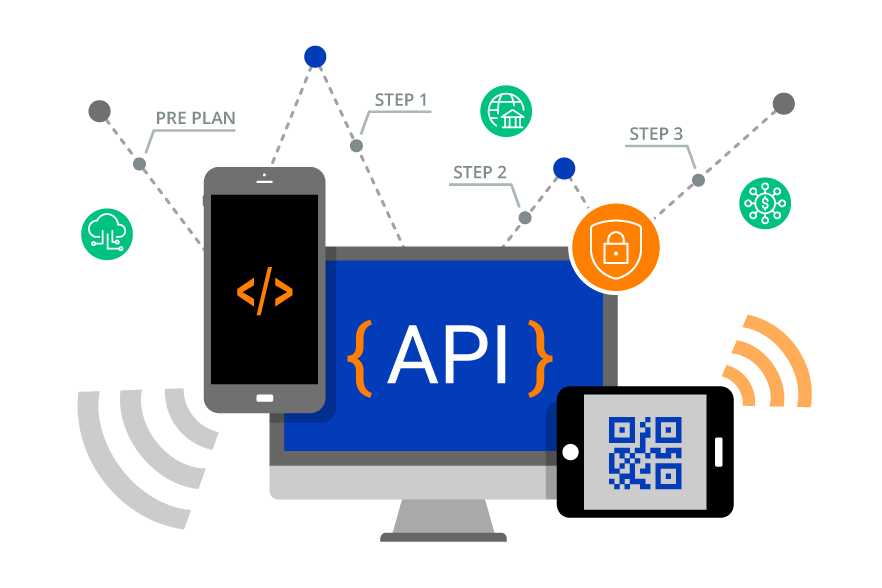